In [1]:
import os, os.path
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
from torchvision import datasets, models, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

Module: Load_data

In [2]:
def get_class_distribution(dataset_obj, idx2class):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [3]:
def load_data(hieroglyph_directory_path, batch_size=20, num_workers=0):
    train_dir = os.path.join(hieroglyph_directory_path, 'train/')
    test_dir = os.path.join(hieroglyph_directory_path, 'test/')

    classes = []

    for filename in os.listdir(train_dir):
        if filename == '.DS_Store':
            pass
        else:
            classes.append(filename)

    classes.sort()

    # print("Our classes:", classes)
    # print(len(classes))

    data_transform = transforms.Compose([transforms.ToTensor(),
                                                transforms.RandomApply([transforms.RandomHorizontalFlip()]),
                                                transforms.RandomRotation(degrees=(-10, 10)),
                                                transforms.RandomAffine(degrees=0, translate=(.1, .1)),
                                                transforms.RandomApply([transforms.ColorJitter(brightness=(1, 1.2),
                                                                                                contrast=(1, 1.5),
                                                                                                saturation=(1, 1.5),
                                                                                                hue=(0, 0.5))]),
                                                transforms.RandomErasing(p=0.5, scale=(0.05, 0.05), ratio=(0.3, 3.3), value=0,
                                                                          inplace=False),
                                                transforms.Resize((100, 100)),
                                                transforms.Normalize((0.5,), (0.5,))])

    train_data = datasets.ImageFolder(train_dir, transform=data_transform)
    test_data = datasets.ImageFolder(test_dir, transform=data_transform)

    # print('Num training images: ', len(train_data))
    # print('Num test images: ', len(test_data))

    # WeightedRandomSampler for train loader
    idx2class = {v: k for k, v in train_data.class_to_idx.items()}

    target_list = torch.tensor(train_data.targets)
    class_count = [i for i in get_class_distribution(train_data, idx2class).values()]
    class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
    class_weights_all = class_weights[target_list]
    weighted_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights_all, num_samples=len(class_weights_all), replacement=True)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               num_workers=num_workers, sampler=weighted_sampler, drop_last=True)
    
    # WeightedRandomSampler for test loader
    idx2class_test = {v: k for k, v in test_data.class_to_idx.items()}

    target_list_test = torch.tensor(test_data.targets)
    class_count_test = [i for i in get_class_distribution(test_data, idx2class_test).values()]
    class_weights_test = 1./torch.tensor(class_count_test, dtype=torch.float) 
    class_weights_all_test = class_weights_test[target_list_test]
    weighted_sampler_test = torch.utils.data.WeightedRandomSampler(weights=class_weights_all_test, num_samples=len(class_weights_all_test), replacement=True)

    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                              num_workers=num_workers, sampler=weighted_sampler_test)
    return train_loader, test_loader, classes

Module: Train_model

In [4]:
def train_model(train_loader, optimizer, conv_net, criterion, my_lr_scheduler, n_epochs):
    # track training loss over time
    losses = []
    
    for epoch in range(1, n_epochs + 1):

        # keep track of training and validation loss
        train_loss = 0.0

        # model by default is set to train
        for batch_i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = conv_net(data)

            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()

            my_lr_scheduler.step()

            if batch_i % 20 == 19:  # print training loss every specified number of mini-batches
                print('Epoch %d, Batch %d loss: %.16f' %
                    (epoch, batch_i + 1, train_loss / 20))
                losses.append(train_loss / 20)
                train_loss = 0.0
        
        

    return conv_net, losses

Module: Test_model

In [5]:
def test_model(classes, conv_net, test_loader, criterion):
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    conv_net.eval()  # eval mode

    labels = []
    predictions = []
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = conv_net(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)

        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(len(target.data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        
        # Will be used for calculating Recall, Precision, and F1-score
        labels.extend(target.data.view_as(pred).tolist())
        predictions.extend(pred.tolist())


    # calculate avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    return test_loss, class_correct, class_total, labels, predictions

Check whether CUDA is available (Change runtime type if not)

In [6]:
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Load Hieroglyph Data

In [7]:
# Connecting and Mounting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
data_dir = '/content/drive/MyDrive/EgyptianHieroglyphDataset_Original_Clean/'

In [9]:
hieroglyph_for_train = []
file_count_list = []

for name in os.listdir('/content/drive/MyDrive/EgyptianHieroglyphDataset_Original_Clean/train/'):
  path, dirs, files = next(os.walk("/content/drive/MyDrive/EgyptianHieroglyphDataset_Original_Clean/train/"+name))
  file_count = len(files)
  print(name, file_count)
  file_count_list.append(file_count)
  hieroglyph_for_train.append(name)

hieroglyph_dict = dict(zip(hieroglyph_for_train, file_count_list))

Y5 6
I9 116
O34 15
V13 63
U7 3
D46 40
E34 97
G1 28
V31 106
S34 8
D36 47
Q1 13
V30 6
F35 2
O4 11
M23 30
S29 212
R8 53
W11 4
X1 185
Y1 1
D21 146
D2 19
E23 8
X8 4
Z1 39
D4 29
V28 28
I10 32
O1 16
M17 291
F31 6
G43 157
D58 28
O49 10
G17 156
R4 2
Q3 61
W24 31
N35 358


Number of images for each hieroglyph 

<BarContainer object of 40 artists>

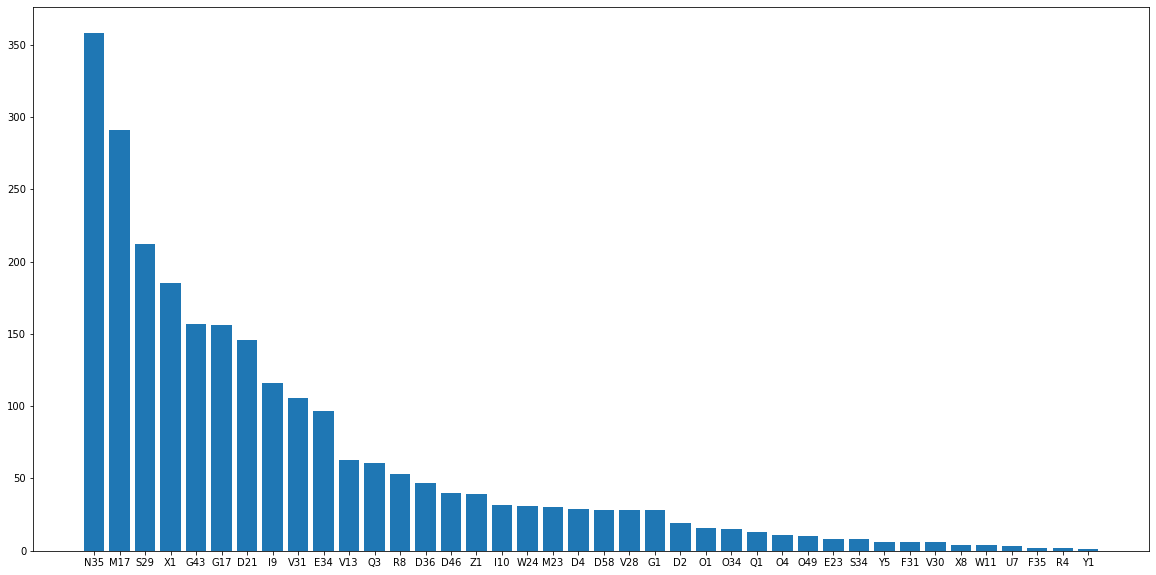

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({"Hieroglyph":hieroglyph_for_train, "Count":file_count_list})

df_sorted= df.sort_values('Count',ascending=False)

plt.figure(figsize=(20,10))
# make bar plot with matplotlib
plt.bar('Hieroglyph', 'Count',data=df_sorted)

In [11]:
# Number of images processed in a single training
batch_size = 20
num_workers = 0

# The load_data function is from hieroglyph_data_preparation python file
train_loader, test_loader, classes = load_data(data_dir)

ResNet Model

In [12]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=3,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

In [13]:
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

In [14]:
'''
class Glyphnet(torch.nn.Module):   
    def __init__(self):
        super(Glyphnet, self).__init__()

        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 0)
        self.maxpool1 = MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 0)
        self.maxpool2 = MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = Linear(23 * 23 * 64, 40)

        #self.conv1 = torch.nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 0)
        #self.conv2 = torch.nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 0)
        #self.maxpool = torch.nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 0)
        #self.avgpool = torch.nn.AvgPool2d(kernel_size=66)

        #self.bn1 = torch.nn.BatchNorm2d(64)
        #self.bn2 = torch.nn.BatchNorm2d(128)
        #self.bn3 = torch.nn.BatchNorm2d(256)
        #self.bn4 = torch.nn.BatchNorm2d(512)

        #self.separableconv1 = SeparableConv2d(64,128)
        #self.separableconv2 = SeparableConv2d(128,128)
        #self.separableconv3 = SeparableConv2d(128,256)
        #self.separableconv4 = SeparableConv2d(256,256)
        #self.separableconv5 = SeparableConv2d(256,512)

        #self.drop_layer = nn.Dropout(p=0.15)
        #self.fc1 = torch.nn.Linear(512, 40) # Should change 64 part
        self.softmax = nn.Softmax(dim=1)

    # Defining the forward pass    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        # x = self.softmax(x) # Not a good idea (the model is trained really slow)

        return x
'''

'\nclass Glyphnet(torch.nn.Module):   \n    def __init__(self):\n        super(Glyphnet, self).__init__()\n\n        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 0)\n        self.maxpool1 = MaxPool2d(kernel_size=2, stride=2)\n        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 0)\n        self.maxpool2 = MaxPool2d(kernel_size=3, stride=2)\n\n        self.fc1 = Linear(23 * 23 * 64, 40)\n\n        #self.conv1 = torch.nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 0)\n        #self.conv2 = torch.nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 0)\n        #self.maxpool = torch.nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 0)\n        #self.avgpool = torch.nn.AvgPool2d(kernel_size=66)\n\n        #self.bn1 = torch.nn.BatchNorm2d(64)\n        #self.bn2 = torch.nn.BatchNorm2d(128)\n        #self.bn3 = torch.nn.BatchNorm2d(256)\n        #self.bn4 = torch.nn.BatchNorm2d(512)\n\n        #self.separableconv1 = Se

In [15]:
class Glyphnet(torch.nn.Module):
   def __init__(self):
      super(Glyphnet, self).__init__()
      
      self.conv1 = torch.nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 0)
      self.conv2 = torch.nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 0)
      self.maxpool = torch.nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 0)
      self.avgpool = torch.nn.AvgPool2d(kernel_size=66)

      self.bn1 = torch.nn.BatchNorm2d(64)
      self.bn2 = torch.nn.BatchNorm2d(128)
      self.bn3 = torch.nn.BatchNorm2d(256)
      self.bn4 = torch.nn.BatchNorm2d(512)

      self.separableconv1 = SeparableConv2d(64,128)
      self.separableconv2 = SeparableConv2d(128,128)
      self.separableconv3 = SeparableConv2d(128,256)
      self.separableconv4 = SeparableConv2d(256,256)
      self.separableconv5 = SeparableConv2d(256,512)

      self.drop_layer = nn.Dropout(p=0.15)
      self.fc1 = torch.nn.Linear(512, 40) # Should change 64 part
      self.softmax = nn.Softmax(dim=1)

   def forward(self, x): # Input: 100 x 100 x 3
      
      # First block
      x = self.bn1(self.conv1(x)) # Output: 98 x 98 x 64
      x = F.relu(self.maxpool(x)) # Output: 96 x 96 x 64
      x = self.bn1(self.conv2(x)) # Output: 94 x 94 x 64
      x = F.relu(self.maxpool(x)) # Output: 92 x 92 x 64
      
      # Second block
      x = F.relu(self.bn2(self.separableconv1(x))) # Output: 90 x 90 x 128
      x = self.bn2(self.separableconv2(x)) # Output: 88 x 88 x 128
      x = F.relu(self.maxpool(x)) # Output: 86 x 86 x 128

      # Third block
      x = F.relu(self.bn2(self.separableconv2(x))) # Output: 84 x 84 x 128
      x = self.bn2(self.separableconv2(x)) # Output: 82 x 82 x 128
      x = F.relu(self.maxpool(x)) # Output: 80 x 80 x 128

      # Fourth block
      x = F.relu(self.bn3(self.separableconv3(x))) # Output: 78 x 78 x 256
      x = self.bn3(self.separableconv4(x)) # Output: 76 x 76 x 256
      x = F.relu(self.maxpool(x)) # Output: 74 x 74 x 256

      # Fifth block
      x = F.relu(self.bn3(self.separableconv4(x))) # Output: 72 x 72 x 256
      x = self.bn3(self.separableconv4(x)) # Output: 70 x 70 x 256
      x = F.relu(self.maxpool(x)) # Output: 68 x 68 x 256

      # Sixth block
      x = F.relu(self.bn4(self.separableconv5(x))) # Output: 66 x 66 x 512

      x = self.avgpool(x) # Global Average Pooling; Output: 512

      x = self.drop_layer(x) # Dropout Layer; Output: 512
      
      # Fully Connected Layer; Output: 512
      x = x.view(x.size(0), -1)
      x = self.fc1(x)

      x = self.softmax(x) # Softmax; Output: 512
      
      return(x)

In [16]:
# Whether to extract features with the model
feature_extract = False
# Other selections
loss_function = "cross-entropy"
model_selection = "glyphnet"
optim_selection = "Adam"

# Load the model
if model_selection == "glyphnet":
    glyphnet = Glyphnet()

# if GPU is available, move the model to GPU
if train_on_gpu:
    glyphnet.cuda()

# Specify loss function (categorical cross-entropy)
if loss_function == "cross-entropy":
    criterion = nn.CrossEntropyLoss()

# Specify optimizer (Adam) and learning rate = 0.001
if optim_selection == "Adam":
    optimizer = optim.Adam(glyphnet.parameters(), lr=0.001)

# Exponential Decay to strengthen learning
decayRate = 0.999
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

Training the model

In [17]:
# number of epochs to train the model
n_epochs = 50

# The train_model function is from model_training python file
glyphnet, train_losses = train_model(train_loader, optimizer, glyphnet, criterion, my_lr_scheduler, n_epochs)

Epoch 1, Batch 20 loss: 3.6824443578720092
Epoch 1, Batch 40 loss: 3.6665638208389284
Epoch 1, Batch 60 loss: 3.6699670791625976
Epoch 1, Batch 80 loss: 3.6577907562255860
Epoch 1, Batch 100 loss: 3.6458096742630004
Epoch 1, Batch 120 loss: 3.6313915967941286
Epoch 2, Batch 20 loss: 3.6055100917816163
Epoch 2, Batch 40 loss: 3.5792318344116212
Epoch 2, Batch 60 loss: 3.6050444722175596
Epoch 2, Batch 80 loss: 3.5976884603500365
Epoch 2, Batch 100 loss: 3.5611370801925659
Epoch 2, Batch 120 loss: 3.5838352084159850
Epoch 3, Batch 20 loss: 3.5750214576721193
Epoch 3, Batch 40 loss: 3.5587122559547426
Epoch 3, Batch 60 loss: 3.5448166251182558
Epoch 3, Batch 80 loss: 3.5229262828826906
Epoch 3, Batch 100 loss: 3.5156610369682313
Epoch 3, Batch 120 loss: 3.5295091867446899
Epoch 4, Batch 20 loss: 3.5175605535507204
Epoch 4, Batch 40 loss: 3.4812143564224245
Epoch 4, Batch 60 loss: 3.5091297030448914
Epoch 4, Batch 80 loss: 3.4807792305946350
Epoch 4, Batch 100 loss: 3.4801833629608154
Epoc

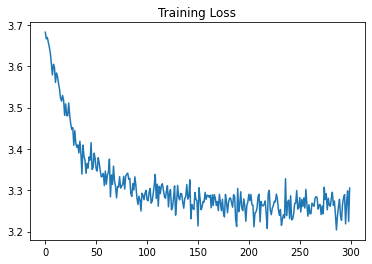

In [18]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.show()

Testing the model

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [20]:
# The test_model function is from model_testing python file
test_loss, class_correct, class_total, labels, predictions = test_model(classes, glyphnet, test_loader, criterion)

# Test accuracy for each hieroglyph
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# Total Test accuracy
print("\nAccuracy: {:.3%}".format(accuracy_score(labels, predictions)))
print("\nPrecision: {:.3%}".format(precision_score(labels, predictions, average = 'weighted')))
print("\nRecall: {:.3%}".format(recall_score(labels, predictions, average = 'weighted')))
print("\nF1-score: {:.3%}".format(f1_score(labels, predictions, average = 'weighted')))

Test Loss: 3.690299

Test Accuracy of    D2:  0% ( 0/14)
Test Accuracy of   D21:  0% ( 0/15)
Test Accuracy of   D36:  0% ( 0/14)
Test Accuracy of    D4:  0% ( 0/15)
Test Accuracy of   D46:  0% ( 0/17)
Test Accuracy of   D58:  0% ( 0/21)
Test Accuracy of   E23:  0% ( 0/17)
Test Accuracy of   E34:  0% ( 0/15)
Test Accuracy of   F31:  0% ( 0/20)
Test Accuracy of   F35:  0% ( 0/14)
Test Accuracy of    G1:  0% ( 0/ 6)
Test Accuracy of   G17:  0% ( 0/15)
Test Accuracy of   G43:  0% ( 0/16)
Test Accuracy of   I10:  0% ( 0/10)
Test Accuracy of    I9:  0% ( 0/20)
Test Accuracy of   M17:  0% ( 0/10)
Test Accuracy of   M23:  0% ( 0/21)
Test Accuracy of   N35:  0% ( 0/14)
Test Accuracy of    O1:  0% ( 0/12)
Test Accuracy of   O34:  0% ( 0/24)
Test Accuracy of    O4:  0% ( 0/16)
Test Accuracy of   O49:  0% ( 0/20)
Test Accuracy of    Q1:  0% ( 0/18)
Test Accuracy of    Q3:  0% ( 0/17)
Test Accuracy of    R4:  0% ( 0/23)
Test Accuracy of    R8:  0% ( 0/13)
Test Accuracy of   S29:  0% ( 0/11)
Test Ac

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
